# AR Detection

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import glob
import os
import numpy.ma as ma
import math
from netCDF4 import stringtochar
import xarray as xr

## Import dataset

In [20]:
avalanche_data = pd.read_csv('/home/mmliu/avalanche_data/CW3E/data/avalanche_data/avalanche_coords_datenum.csv')
avalanche_data_dates = pd.read_csv('/home/mmliu/avalanche_data/CW3E/data/avalanche_data/avalanche_coords_partial.csv')
avalanche_data_datenum = pd.read_csv('/home/mmliu/avalanche_data/CW3E/data/avalanche_data/avalanche_coords_datenum_datesort.csv')

# Rutz AR Catalog
ARdata = xr.open_dataset("/data/downloaded/Reanalysis/AR_Catalogs/Rutz/MERRA2/AnnualFiles/Rutz_ARCatalog_MERRA2_2020.nc")

## Let's take 2020 as an example

## First we splice the dates for avalanche events in 2020

In [23]:
start_2020 = 18262
year_2020 = avalanche_data_datenum[98:118].reset_index()
# calculating the number of days after 1st jan
days_diff = []
for j in range(len(year_2020)):
    diff = year_2020['date'][j] - start_2020
    days_diff.append(diff)

### Initializing index for north america

In [125]:
westUS_lon = ARdata.longitude[80:129]
# Index 80 is -130 Index 129 is -100 (so 130 W and 100 W)

westUS_lat = ARdata.latitude[230:281]
# Index 230 is 25 N, Index 281 is 50 N

### Function to round longitude to its nearest values

In [77]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [101]:
## Drop Alaska for now
year_2020 = year_2020.drop(index = [7,9,10])
year_2020 = year_2020.reset_index(drop=True)
year_2020

,index,state,date,lat,lon,site_name
0,98,ID,18268,47.49,-116.14,"Wardner Peak, Bitterroot Mountains"
1,99,OR,18272,44.86,-118.19,"Rock Creek, Elkhorn Mountains"
2,100,ID,18276,43.69,-114.66,"Baker Creek drainage, Smoky Mountains"
3,101,CA,18278,39.16,-120.23,"Scott Peak, west of Lake Tahoe"
4,102,CO,18279,37.98,-107.66,"Uncompahgre Gorge, south of Ouray"
5,103,UT,18279,40.98,-111.82,"Farmington Canyon, east of Farmington"
6,104,WA,18284,47.48,-120.66,Near Blewett Pass
7,106,CO,18307,39.69,-106.47,"South Fork of Dickson Creek, east of Red and W..."
8,109,ID,18336,42.78,-112.15,North of Skyline Peak
9,110,WY,18353,43.53,-110.98,"Taylor Mountain, northwest of Teton Pass"


## Creating date and coordinate range

In [106]:
# creating the avalanche day range
day_range = []
for i in range(len(days_diff)):
    ava_day = days_diff[i]
    start = ava_day - 6
    end = ava_day + 1
    period = [start*8,end*8]
    day_range.append(period)
    
# creating the avalanche lat range
lat_range = []
west_US_lat_base = 230
for i in range(len(year_2020)):
    # creating the range value
    ava_lat = int(np.ceil(year_2020['lat'][i]))
    start = ava_lat - 5
    end = ava_lat + 1
    
    # converting it into the correct index    
    lat_start = 230 + np.where(westUS_lat == start)[0][0]
    lat_end = 230 + np.where(westUS_lat == end)[0][0]

    period = [lat_start,lat_end]
    lat_range.append(period)
    
    
# creating the avalanche lon range
lon_range = []
west_US_lon_base = 80
for i in range(len(year_2020)):
    ava_lon = int(np.ceil(year_2020['lon'][i]))
    start = ava_lon - 5
    end = ava_lon + 1

    # finding the value in the list
    num_start = find_nearest(westUS_lon, start)
    num_end = find_nearest(westUS_lon, end)
    
    # converting it into the correct index    
    lon_start = 80 + np.where(westUS_lon == num_start)[0][0]
    lon_end = 80 + np.where(westUS_lon == num_end)[0][0]

    period = [lon_start,lon_end]
    lon_range.append(period)
    

### Run algorithm to check which avalanches are guaranteed to br AR related

In [35]:
for n in range(len(year_2020)):
    entry = ARdata.ARs.isel(ntim =slice(day_range[n][0],day_range[n][1]),nlat=slice(lat_range[n][0],lat_range[n][1]),nlon=slice(lon_range[n][0],lon_range[n][1]))
    for i in range(len(entry.ntim)):
        for j in range(len(entry.nlat)):
            for k in range(len(entry.nlon)):
                if entry[i][j][k] == 1:
                    print('index number',n , 'is an AR related avalanche')
                else:
                    pass


<xarray.DataArray 'latitude' (nlat: 49)>
array([-50. , -49.5, -49. , -48.5, -48. , -47.5, -47. , -46.5, -46. , -45.5,
       -45. , -44.5, -44. , -43.5, -43. , -42.5, -42. , -41.5, -41. , -40.5,
       -40. , -39.5, -39. , -38.5, -38. , -37.5, -37. , -36.5, -36. , -35.5,
       -35. , -34.5, -34. , -33.5, -33. , -32.5, -32. , -31.5, -31. , -30.5,
       -30. , -29.5, -29. , -28.5, -28. , -27.5, -27. , -26.5, -26. ])
Dimensions without coordinates: nlat

## Next itdentify the lat/lon points in the AR Catalog for a given avalanche event

### Avalanche event is decided based off the date range

In [130]:
event = 1
start = day_range[event][0]
end = day_range[event][1]

start_lat = lat_range[event][0]
end_lat = lat_range[event][1]

start_lon = lon_range[event][0]
end_lon = lon_range[event][1]

time = ARdata.ntim[start:end]

In [127]:
AR_flagged_2020 = {new_list: [] for new_list in np.arange(start,end+1)}

In [145]:
westUS_lat

<xarray.DataArray 'latitude' (nlat: 51)>
array([25. , 25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5,
       31. , 31.5, 32. , 32.5, 33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5,
       37. , 37.5, 38. , 38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5,
       43. , 43.5, 44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5,
       49. , 49.5, 50. ])
Dimensions without coordinates: nlat

In [154]:
entry = ARdata.ARs.isel(ntim =slice(start,end),nlat=slice(230,281),nlon=slice(80,129))
entry

<xarray.DataArray 'ARs' (ntim: 64, nlat: 51, nlon: 49)>
[159936 values with dtype=float64]
Dimensions without coordinates: ntim, nlat, nlon
Attributes:
    units:    (binary)

In [155]:
# This is used to slice the AR catalog to just the West US and for just a particular avalanche incident
entry = ARdata.ARs.isel(ntim =slice(start,end),nlat=slice(230,281),nlon=slice(80,129))

# Index 80 is -130 Index 129 is -100 (so 130 W and 100 W); LON

# Index 230 is 25 N, Index 281 is 50 N; LAT

for i in range(len(entry.ntim)):
    key = str(time.data[i])
    for j in range(len(entry.nlat)):
        for k in range(len(entry.nlon)):
            if entry[i][j][k].data == 1:
                AR_flagged_2020[time.data[i]].append([westUS_lon.data[k], westUS_lat.data[j]])
            else:
                pass

## Plotting

In [156]:
AR_flagged_2020

{32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [[-130.0, 42.5],
  [-129.375, 42.5],
  [-130.0, 43.0],
  [-129.375, 43.0],
  [-128.75, 43.0],
  [-130.0, 43.5],
  [-129.375, 43.5],
  [-128.75, 43.5],
  [-128.125, 43.5],
  [-130.0, 44.0],
  [-129.375, 44.0],
  [-128.75, 44.0],
  [-128.125, 44.0],
  [-130.0, 44.5],
  [-129.375, 44.5],
  [-128.75, 44.5],
  [-128.125, 44.5],
  [-127.5, 44.5],
  [-130.0, 45.0],
  [-129.375, 45.0],
  [-128.75, 45.0],
  [-128.125, 45.0],
  [-127.5, 45.0],
  [-130.0, 45.5],
  [-129.375, 45.5],
  [-128.75, 45.5],
  [-128.125, 45.5],
  [-130.0, 46.0],
  [-129.375, 46.0],
  [-128.75, 46.0],
  [-128.125, 46.0],
  [-130.0, 46.5],
  [-129.375, 46.5],
  [-128.75, 46.5],
  [-130.0, 47.0],
  [-129.375, 47.0]],
 40: [[-130.0, 42.5],
  [-129.375, 42.5],
  [-128.75, 42.5],
  [-128.125, 42.5],
  [-127.5, 42.5],
  [-130.0, 43.0],
  [-129.375, 43.0],
  [-128.75, 43.0],
  [-128.125, 43.0],
  [-127.5, 43.0],
  [-126.875, 43.0],
  [-130.0, 43.5],
  [-129.375,

In [120]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [158]:
special = []
dates = np.arange(start,end+1)
for date in dates:
    if len(AR_flagged_2020[date]) == 0:
        pass
    else:
        special.append(date)


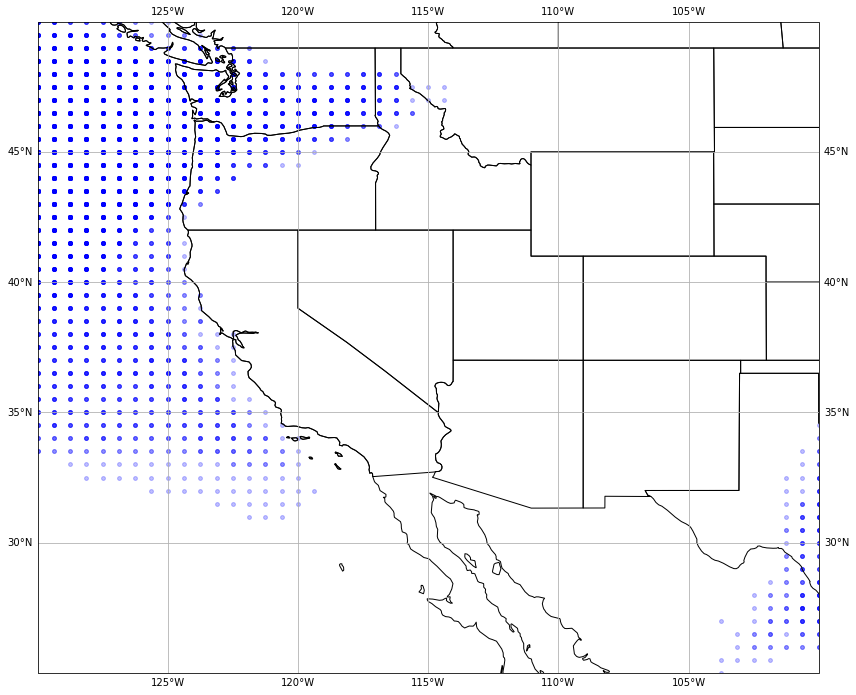

In [159]:
fig = plt.figure(figsize=(14, 14))
m6 = plt.axes(projection=ccrs.PlateCarree())
# (x0, x1, y0, y1)
# US SIZE: -130, -100, 20, 55
m6.set_extent([-130, -100, 25, 50], ccrs.PlateCarree())         
m6.add_feature(cfeature.STATES)
m6.coastlines()

grid_lines = m6.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

for j in range(1):
    date = special[j]
    for i in range(len(AR_flagged_2020[date])):
        m6.scatter(AR_flagged_2020[date][i][0], AR_flagged_2020[date][i][1], color='blue', s=15, alpha=0.25, transform=ccrs.PlateCarree())
